In [1]:
import habitat
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision.models as models
from My_projects.Mapper.Vec_env import create_envs
from My_projects.Mapper.Monocular_depth_estimation.Model import Model
from My_projects.Mapper.Monocular_depth_estimation.Utils import AverageMeter
from My_projects.Mapper.Monocular_depth_estimation.Loss import ssim

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

### Создаем архитектуру нейронной сети мапера

In [2]:
net = Model()

### Загружаем сеть на видеокарту

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

cuda:1


### Обчуаем нашу сеть на карты глубины

In [4]:
import torch.nn as nn

def train(net, X_train, y_train, X_test, y_test):
    
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    losses_train = AverageMeter()
    losses_test = AverageMeter()
    
    train_loss = []
    test_loss = []
        
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    l1_criterion = nn.L1Loss()
    
    batch_size = 400
    
    for epoch in range(30):
        torch.cuda.empty_cache()
        order = np.random.permutation(len(X_train))
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            
            output = net.forward(X_batch)
            
            l_depth = l1_criterion(output, y_batch)
            l_ssim = torch.clamp((1 - ssim(output, y_batch, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
            loss = (1.0 * l_ssim) + (0.1 * l_depth)
            losses_train.update(loss.data.item(), X_batch.size(0))
            
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()
            
#         scheduler.step()
        
        with torch.no_grad():
            net.eval()
            torch.cuda.empty_cache()
            
            order = np.random.permutation(len(X_test))
            for start_index in range(0, len(X_test), batch_size):
                batch_indexes = order[start_index:start_index+batch_size]
                X_batch = X_test[batch_indexes].to(device)
                y_batch = y_test[batch_indexes].to(device)
                
                output = net.forward(X_batch)
                l_depth = l1_criterion(output, y_batch)
                l_ssim = torch.clamp((1 - ssim(output, y_batch, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)
                loss = (1.0 * l_ssim) + (0.1 * l_depth)
                losses_test.update(loss.data.item(), X_batch.size(0))
                
        train_loss.append(losses_train.val)
        test_loss.append(losses_test.val)
        print('epoch {} : train_loss = {}, test_loss = {}'.format(epoch, train_loss[-1], test_loss[-1]))
        
    return train_loss, test_loss

In [5]:
X_train = torch.load('./data_big.pt')['X_train']
y_train = torch.load('./data_big.pt')['y_train']
X_test = torch.load('./data.pt')['X_test']
y_test = torch.load('./data.pt')['y_test']

In [6]:
train_loss, test_loss = train(net, X_train, y_train, X_test, y_test)

epoch 0 : train_loss = 0.006375727243721485, test_loss = 0.007546417880803347
epoch 1 : train_loss = 0.003641950897872448, test_loss = 0.004672379232943058
epoch 2 : train_loss = 0.003225072054192424, test_loss = 0.003961984999477863
epoch 3 : train_loss = 0.003027906408533454, test_loss = 0.004291543737053871
epoch 4 : train_loss = 0.0028095219749957323, test_loss = 0.003884444944560528
epoch 5 : train_loss = 0.002835872583091259, test_loss = 0.0037245973944664
epoch 6 : train_loss = 0.0028043584898114204, test_loss = 0.003909129649400711
epoch 7 : train_loss = 0.0022755302488803864, test_loss = 0.0036622844636440277
epoch 8 : train_loss = 0.0025424847844988108, test_loss = 0.00369457365013659
epoch 9 : train_loss = 0.0019944715313613415, test_loss = 0.0036541216541081667
epoch 10 : train_loss = 0.0019554253667593002, test_loss = 0.0034777869004756212
epoch 11 : train_loss = 0.0019354642136022449, test_loss = 0.0034448355436325073
epoch 12 : train_loss = 0.0017663410399109125, test_lo

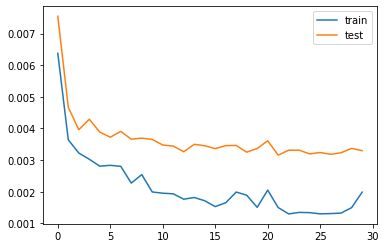

In [15]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(len(train_loss))], train_loss, label='train')
plt.plot([i for i in range(len(test_loss))], test_loss, label='test')
plt.legend()
plt.show()

### Сохраняем обученную сеть

In [8]:
torch.save(net.state_dict(), 'depth_net.pt')

### Визуально проверяем качество работы сети

In [26]:
scen_num = 22
x = X_test[scen_num]
x = x.unsqueeze(0)
x = x.to(device)
my_depth = net.forward(x)
my_depth = my_depth.permute(0, 3, 2, 1)
my_depth_numpy = my_depth.cpu().detach().numpy()[0]
my_depth_numpy.shape

(256, 256, 1)

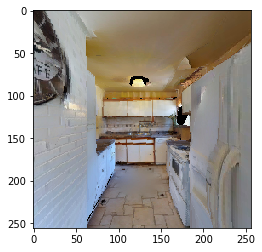

In [27]:
rgb = X_test[scen_num].permute(2, 1, 0)
plt.imshow(rgb.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


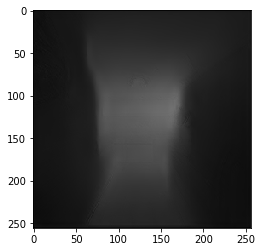

In [28]:
plt.imshow(np.concatenate((my_depth_numpy, my_depth_numpy,my_depth_numpy), axis=2))

In [29]:
test_depth = y_test[scen_num] 
test_depth = test_depth.permute(2,1,0)
test_depth_numpy = test_depth.cpu().detach().numpy()
test_depth_numpy.shape

(256, 256, 1)

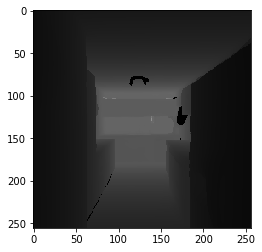

In [30]:
plt.imshow(np.concatenate((test_depth_numpy, test_depth_numpy, test_depth_numpy), axis=2))

In [32]:
scen_num = 9
x = X_test[scen_num]
x = x.unsqueeze(0)
x = x.to(device)
my_depth = net.forward(x)
my_depth = my_depth.permute(0, 3, 2, 1)
my_depth_numpy = my_depth.cpu().detach().numpy()[0]
my_depth_numpy.shape

(256, 256, 1)

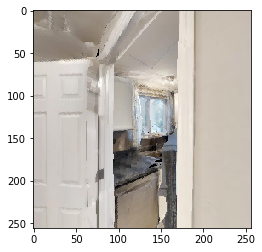

In [33]:
rgb = X_test[scen_num].permute(2, 1, 0)
plt.imshow(rgb.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


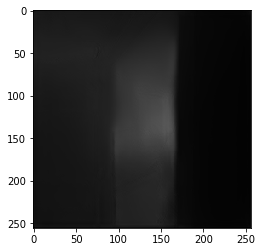

In [34]:
plt.imshow(np.concatenate((my_depth_numpy, my_depth_numpy,my_depth_numpy), axis=2))

In [35]:
test_depth = y_test[scen_num] 
test_depth = test_depth.permute(2,1,0)
test_depth_numpy = test_depth.cpu().detach().numpy()
test_depth_numpy.shape

(256, 256, 1)

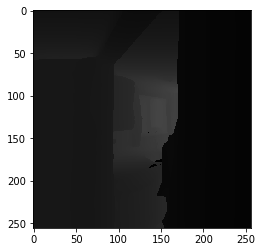

In [36]:
plt.imshow(np.concatenate((test_depth_numpy, test_depth_numpy, test_depth_numpy), axis=2))